In [1]:
import numpy as np
import pandas as pd
import cv2
import os
import random
import copy
from PIL import Image
from glob import glob

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, accuracy_score, confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

import torch
import torchvision
import torch.nn.functional as F
import torch.optim as optim
from torch import nn
from torchvision import transforms, models
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
from torch.utils.data import Dataset, DataLoader, ConcatDataset

import matplotlib.pyplot as plot
from matplotlib.image import imread
%matplotlib inline

In [2]:
# Set random seed for reproducibility
rng_seed = 2020
np.random.seed(rng_seed)
torch.manual_seed(rng_seed);

## Dataset Preparation

TODO

In [3]:
trainpath = '../input/chest-xray-pneumonia/chest_xray/chest_xray/train'
validpath = '../input/chest-xray-pneumonia/chest_xray/chest_xray/val'
testpath  = '../input/chest-xray-pneumonia/chest_xray/chest_xray/test'

In [4]:
class PneumoniaDataset(Dataset):
    """
        PneumoniaDataset - Dataset class used to extract samples from 
        dataset and provides simple preview tools to showcase images in
        the dataset.
    """
    def __init__(self,
        dataframe,
        classes = {'NORMAL', 'PNEUMONIA'},
        transform = None
    ):
        self.dataframe = dataframe
        self.transform = transform
        
    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self, index):
        sample = self.dataframe.iloc[index]
        image  = Image.open(sample['Image']).convert('RGB')
        label  = sample['Label']
        
        if self.transform is not None:
            tform = transforms.Compose([
                transforms.Resize(255),
                transforms.CenterCrop(224),
                self.transform[sample['Transform']],
                transforms.ToTensor()
            ])
            image = tform(image)
        else:
            tform = transforms.Compose([
                transforms.Resize(255),
                transforms.CenterCrop(224),
                transforms.ToTensor()
            ])
            image = tform(image)
            
        return image, label

In [5]:
# Create datasets:
transform_set = (
    transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.RandomGrayscale(),
        transforms.RandomAffine(translate=(0.05,0.05), degrees=0)
    ]),
    transforms.Compose([
        transforms.RandomHorizontalFlip(p=1),
        transforms.RandomGrayscale(),
        transforms.RandomAffine(translate=(0.1,0.05), degrees=10)
    ]),
    transforms.Compose([
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(15),
        transforms.RandomGrayscale(p=1),
        transforms.RandomAffine(translate=(0.08,0.1), degrees=15)
    ])
)

In [6]:
get_entry = lambda path, label, tform : [(os.path.join(path,f),label,tform) for f in os.listdir(path) if f.endswith(".jpeg")]
entries   = get_entry(trainpath + '/NORMAL'   , 0, 0) + \
            get_entry(trainpath + '/PNEUMONIA', 1, 0) + \
            get_entry(trainpath + '/NORMAL'   , 0, 1) + \
            get_entry(trainpath + '/NORMAL'   , 0, 2) + \
            get_entry(validpath + '/NORMAL'   , 0, 0) + \
            get_entry(validpath + '/PNEUMONIA', 1, 0)
dataframe = pd.DataFrame(entries, columns = ['Image','Label','Transform'])

# Randomly sample and split training and validation sets:
normal    = np.where(dataframe['Label'] == 0)[0]
pneumonia = np.where(dataframe['Label'] == 1)[0]

normal_train, normal_valid = train_test_split(normal, test_size = 0.3, shuffle = True)
pneumonia_train, pneumonia_valid = train_test_split(pneumonia, test_size = 0.3, shuffle = True)

# Training and validation samples:
train_samples = np.append(normal_train, pneumonia_train)
valid_samples = np.append(normal_valid, pneumonia_valid)
np.random.shuffle(train_samples)
np.random.shuffle(valid_samples)

trainframe = dataframe.loc[train_samples]
validframe = dataframe.loc[valid_samples]

In [7]:
trainset = PneumoniaDataset(trainframe, transform = transform_set)
validset = PneumoniaDataset(trainframe, transform = transform_set)

batch_size  = 32
trainloader = DataLoader(trainset, batch_size * 1, shuffle = True,  num_workers = 4)
validloader = DataLoader(trainset, batch_size * 2, shuffle = False, num_workers = 4)

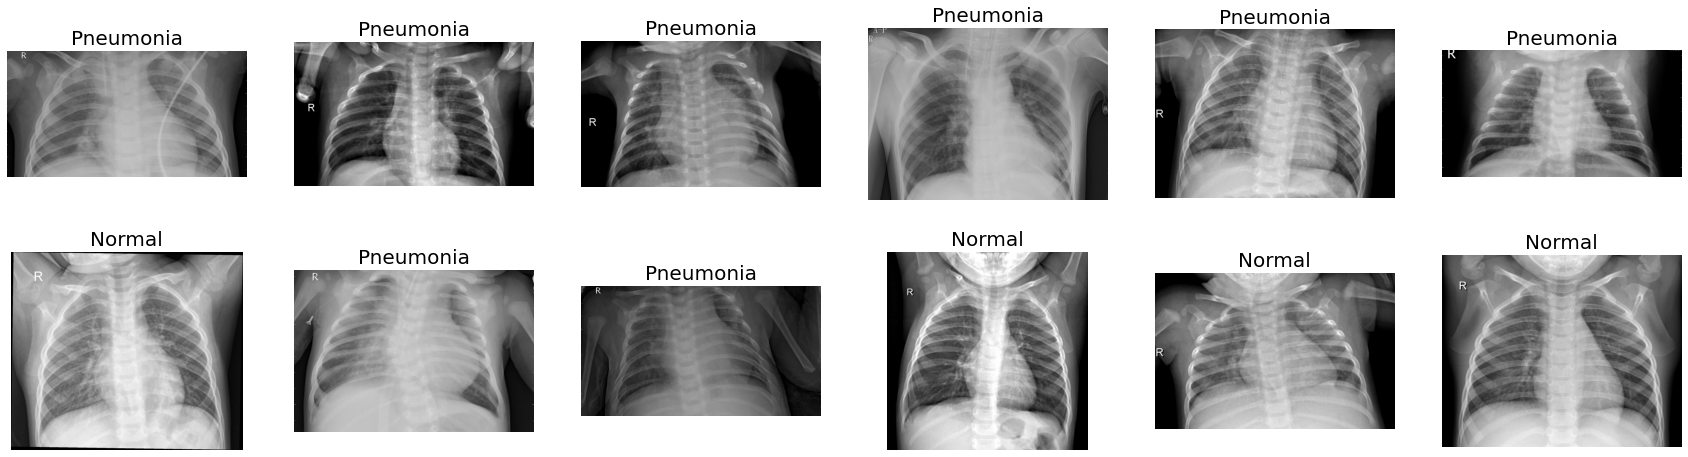

In [8]:
rows, cols = 2, 6
fig, axes  = plot.subplots(nrows = rows, ncols = cols, figsize = (30,8))
classes    = ("Normal", "Pneumonia")
for n in range(12):
    sample = trainframe.iloc[n]
    image  = cv2.cvtColor(imread(sample['Image']), cv2.COLOR_BGR2RGB)
    axis   = axes[n // cols][n % cols]
    axis.imshow(image)
    axis.set_title(classes[sample['Label']], fontsize=20)
    axis.axis('off')

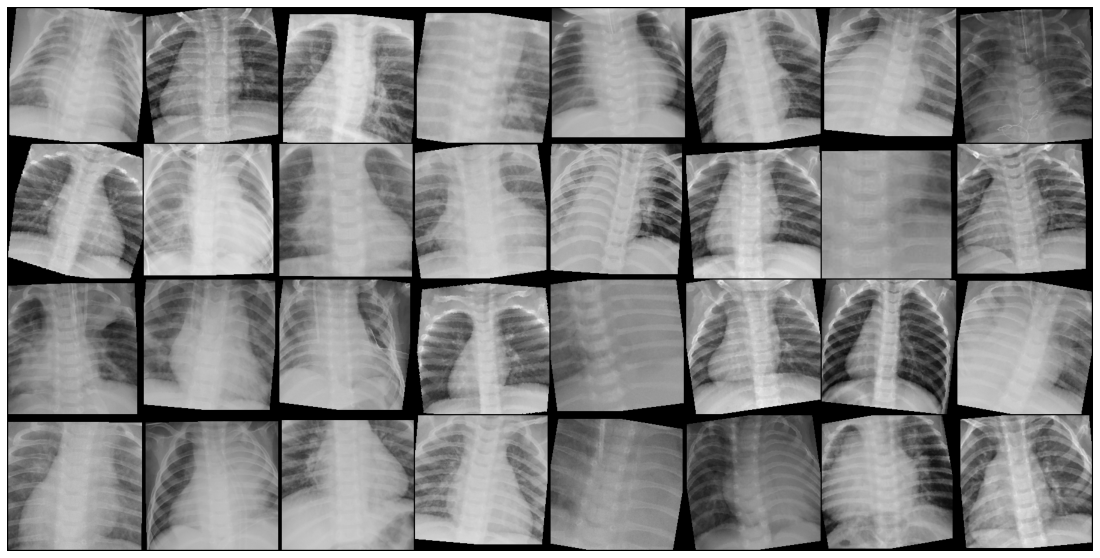

In [9]:
batch, _ = next(iter(trainloader))
fig, ax = plot.subplots(figsize=(30,10))
ax.axis('off')
ax.imshow(make_grid(batch[:60], nrow=8).permute(1, 2, 0));

In [10]:
net = torchvision.models.densenet161(pretrained = True)
net.classifier = nn.Linear(net.classifier.in_features, 2)
net.load_state_dict(torch.load('../input/trained-models/densenet-classifier-layer.pth'))

Downloading: "https://download.pytorch.org/models/densenet161-8d451a50.pth" to /root/.cache/torch/hub/checkpoints/densenet161-8d451a50.pth


  0%|          | 0.00/110M [00:00<?, ?B/s]

<All keys matched successfully>

In [11]:
# Use these steps for transfer learning the classifier layer alone:
# for param in net.parameters():
#    param.requires_grad = False
#    
# net.classifier = nn.Linear(net.classifier.in_features, 2)

Step 1: Retrain the classification layer only in the first attempt to train the model using the features from the pretrained model itself.

In [12]:
def trainer(
    network,
    optimizer,
    criterion,
    trainloader,
    lrscheduler = None,
    validloader = None,
    num_epochs = 10
):
    # Determine the device to train on: CPU / GPU
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    network.to(device)
    
    # Store the best model of the epochs:
    best_model = copy.deepcopy(network.state_dict())
    best_accuracy = 0.0
    
    # Output loss and accuracy containers:
    loss     = {'Train': np.zeros((num_epochs,1), dtype = np.float32), 
                'Valid': np.zeros((num_epochs,1), dtype = np.float32)}
    accuracy = {'Train': np.zeros((num_epochs,1), dtype = np.float32), 
                'Valid': np.zeros((num_epochs,1), dtype = np.float32)}
    
    for epoch in range(num_epochs):
        # Enable model training:
        network.train()
        
        # Containers for running loss and accuracy:
        train_acc  = 0.0
        train_loss = 0.0
        
        for itr, traindata in enumerate(trainloader,0):
            # forward - backward step:
            train_batch, train_labels = traindata         
            train_batch, train_labels = train_batch.to(device), train_labels.to(device)
            optimizer.zero_grad()
            
            output  = network(train_batch)
            
            batch_loss = criterion(output, train_labels)
            batch_loss.backward()
            optimizer.step()
            train_loss += batch_loss.item()
            
            # Compute accuracy:
            _, pred    = torch.max(output, 1)
            train_acc += torch.sum(pred == train_labels.data)
            
            if itr % 30 == 29:
                print('[%d, %5d] loss: %.3f' % (epoch + 1, itr + 1, train_loss / (itr+1)))
            
        loss['Train'][epoch] = train_loss / len(trainloader.dataset)
        accuracy['Train'][epoch] = train_acc.cpu() / len(trainloader.dataset)
        
        # Perform validation:
        if validloader is not None:

            # Containers for running loss and accuracy:
            val_acc  = 0.0
            val_loss = 0.0

            with torch.no_grad():
                network.eval()

                for val_batch, val_labels in validloader:
                    val_batch, val_labels = val_batch.to(device), val_labels.to(device)
                    output = network(val_batch)
                    val_loss += criterion(output, val_labels)

                    # Compute accuracy:
                    _, pred  = torch.max(output, 1)
                    val_acc += torch.sum(pred == val_labels.data)

                loss['Valid'][epoch] = val_loss.cpu() / len(validloader.dataset)
                accuracy['Valid'][epoch] = val_acc.cpu() / len(validloader.dataset)

                # save best model:
                if accuracy['Valid'][epoch] > best_accuracy:
                    best_accuracy = accuracy['Valid'][epoch]
                    best_model = copy.deepcopy(network.state_dict())

        torch.save(best_model, './best-model.pth')
        if lrscheduler is not None:          
            lrscheduler.step()
    
        # print statistics:
        print('[%3d/%3d] Train:[loss: %.3f, accuracy: %.3f] Valid:[loss: %.3f, accuracy: %.3f]' % (
            epoch + 1, num_epochs, 
            loss['Train'][epoch], accuracy['Train'][epoch],
            loss['Valid'][epoch], accuracy['Valid'][epoch]
        ))
    
    print('Training Complete!')
    print('Best Accuracy: %.3f. Model saved to "./best-model.pth".' % best_accuracy)
    
    return loss, accuracy

In [13]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.0001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 2, gamma=0.1)
device    = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

loss, accuracy = trainer(
    net, optimizer, criterion, trainloader, 
    lrscheduler = scheduler, 
    validloader = validloader
)

[1,    30] loss: 0.099
[1,    60] loss: 0.130
[1,    90] loss: 0.124
[1,   120] loss: 0.115
[1,   150] loss: 0.101
[  1/ 10] Train:[loss: 0.003, accuracy: 0.967] Valid:[loss: 0.003, accuracy: 0.945]
[2,    30] loss: 0.088
[2,    60] loss: 0.094
[2,    90] loss: 0.088
[2,   120] loss: 0.078
[2,   150] loss: 0.073
[  2/ 10] Train:[loss: 0.002, accuracy: 0.975] Valid:[loss: 0.000, accuracy: 0.990]
[3,    30] loss: 0.027
[3,    60] loss: 0.032
[3,    90] loss: 0.030
[3,   120] loss: 0.028
[3,   150] loss: 0.028
[  3/ 10] Train:[loss: 0.001, accuracy: 0.988] Valid:[loss: 0.000, accuracy: 0.994]
[4,    30] loss: 0.020
[4,    60] loss: 0.023
[4,    90] loss: 0.024
[4,   120] loss: 0.025
[4,   150] loss: 0.022
[  4/ 10] Train:[loss: 0.001, accuracy: 0.992] Valid:[loss: 0.000, accuracy: 0.995]
[5,    30] loss: 0.027
[5,    60] loss: 0.024
[5,    90] loss: 0.027
[5,   120] loss: 0.024
[5,   150] loss: 0.024
[  5/ 10] Train:[loss: 0.001, accuracy: 0.992] Valid:[loss: 0.000, accuracy: 0.996]
[6,  

In [14]:
entries    = get_entry(testpath + '/NORMAL'   , 0, 0) + \
             get_entry(testpath + '/PNEUMONIA', 1, 0)
testframe  = pd.DataFrame(entries, columns = ['Image','Label','Transform'])
testset    = PneumoniaDataset(testframe)
testloader = DataLoader(testset, batch_size = batch_size)
results    = testframe.copy()
results.drop(columns = 'Transform');

In [15]:
net.load_state_dict(torch.load('./best-model.pth'))
net.to(device)
with torch.no_grad():
    net.eval()
    
    predictions = []
    labels      = []
    
    for testbatch, testlabels in testloader:
        testbatch, testlabels = testbatch.to(device), testlabels.to(device)
        output = net(testbatch)
        loss = criterion(output, testlabels)
        _, pred  = torch.max(output, 1)
        
        predictions = predictions + pred.tolist()
        labels      = labels + testlabels.tolist()
        
# Add results to results frame:
results = results.assign(Prediction = predictions)
results = results.assign(TestLabel = labels)

<Figure size 432x288 with 0 Axes>

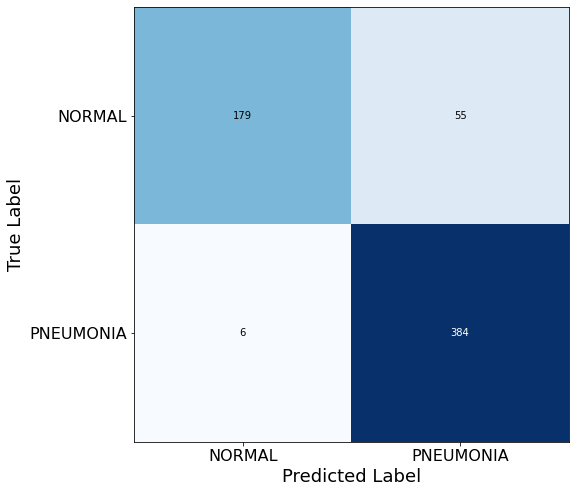

In [16]:
cm  = confusion_matrix(results['TestLabel'], results['Prediction'])
plot.figure()
plot_confusion_matrix(cm, figsize=(12,8), cmap = plot.cm.Blues)
plot.xticks(range(2), ['NORMAL', 'PNEUMONIA'], fontsize=16)
plot.yticks(range(2), ['NORMAL', 'PNEUMONIA'], fontsize=16)
plot.xlabel('Predicted Label',fontsize=18)
plot.ylabel('True Label',fontsize=18)
plot.show()

In [17]:
tn, fp, fn, tp = cm.ravel()

accuracy  = sum(results['Prediction'] == results['TestLabel']) / len(results['TestLabel'])
precision = tp/(tp+fp)
recall    = tp/(tp+fn)
f1        = 2 * ((precision * recall)/(precision + recall))

print("[Accuracy %.2f] [Recall %.2f] [Precision %.2f] [F1 %.2f]" % (accuracy, recall, precision, f1))

[Accuracy 0.90] [Recall 0.98] [Precision 0.87] [F1 0.93]
